In [60]:
import pandas as pd
import numpy as np
import random
from joblib import dump, load
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import statistics

In [2]:
features = pd.read_pickle('data/features.pickle')
features = features.drop(['delivery_duration', 'syntetic_delivery_duration', 'products_bought'], axis=1)

Delivery info is appended after purchase - it makes no sense to take those columns as features because prediction about conversion takes place before purchase. Same with products_bought column.

In [3]:
def train_and_test(df: pd.DataFrame, x_cols, y_col, runs=1, silent=False):
    scores = []
    for i in range(runs):
        train, test = train_test_split(df, test_size=0.3)
        clf = svm.SVC()
        clf.fit(train[x_cols], train[y_col])
        correct = test[y_col] == clf.predict(test[x_cols])
        scores.append(correct.sum() / len(correct))
    score = statistics.mean(scores)
    if not silent:
        print(f'the score of model B is {round(score, 4)}')
    return score

This function will be used to quickly calculate score of our model.

# Preprocessing

In [4]:
features.dtypes

made_purchase               bool
events_count               int64
product_views              int64
total_duration           float64
mean_event_duration      float64
products_viewed           object
mean_time_per_product    float64
user_id                  float64
is_female                   bool
weekday_cos_min          float64
weekday_cos_max          float64
weekday_sin_min          float64
weekday_sin_max          float64
hour_sin_min             float64
hour_sin_max             float64
hour_cos_min             float64
hour_cos_max             float64
cat_0                     object
cat_1                     object
cat_2                     object
cat_3                     object
syntetic_duration           bool
dtype: object

Feature matrix contains mostly real number or integer values but there are some non numerical types that we must take care of.

## Label encoding

Our dataset contains categorical features that must be encoded.

In [5]:
objects = features.select_dtypes(include=['object']).columns
features[objects].head()

,products_viewed,cat_0,cat_1,cat_2,cat_3
session_id,,,,,
100001.0,{1001.0},{telefony i akcesoria},{telefony stacjonarne},{},{}
100002.0,"{1276.0, 1277.0}",{komputery},{tablety i akcesoria},{tablety},{}
100003.0,"{1276.0, 1277.0}",{komputery},{tablety i akcesoria},{tablety},{}
100004.0,"{1030.0, 1032.0, 1033.0, 1034.0, 1036.0, 1037....",{komputery},{monitory},{monitory lcd},{}
100005.0,"{1233.0, 1234.0}",{sprzęt rtv},{video},{odtwarzacze dvd},{}


Because those columns are sets of categories, there are at least two ways we can encode them.

### One hot encoding

In [6]:
encoded_objects = []
for col in objects:
    encoded_objects.append(pd.get_dummies(features[col].apply(str)))
one_hot = features.drop(objects, axis=1)
one_hot = pd.concat([one_hot] + encoded_objects, axis=1)
one_hot.shape

(9714, 2065)

In [7]:
x_cols = one_hot.drop('made_purchase', axis=1).columns
y_col = 'made_purchase'
train_and_test(one_hot.reset_index(drop=True), x_cols, y_col)

the score of model B is 0.9297


0.9296740994854202

After performing one hot encoding on columns that are sets of labels we have 2068 features - this value could be reduced if we encoded the presence of any particular category with a boolean flag. That way a set of two labels would have two columns with True value. This also makes sense when adding two vectors - adding a set with label A to a set with label B will result in a set that contains both label A and label B. We will try and create another DataFrame, this time using the second technique.

### Multi hot encoding

In [8]:
def multi_hot_encoder(s: pd.Series):
    result = pd.DataFrame(index=s.index)
    numpy_data = pd.DataFrame(s.apply(list).tolist()).to_numpy()
    clean = numpy_data[np.logical_not(pd.isna(numpy_data))]
    unique = np.unique(clean)    
    for c in unique:
        result[c] = s.apply(lambda r: c in r)
    return result

In [9]:
encoded_objects = []
for col in objects:
    encoded_objects.append(multi_hot_encoder(features[col]))
multi_hot = features.drop(objects, axis=1)
multi_hot = pd.concat([multi_hot] + encoded_objects, axis=1)
multi_hot.shape

(9714, 118)

That method returned an encoded dataset with as few as 121 features.

In [10]:
x_cols = multi_hot.drop('made_purchase', axis=1).columns
y_col = 'made_purchase'
train_and_test(multi_hot.reset_index(drop=True), x_cols, y_col)

the score of model B is 0.942


0.942024013722127

Although model a with multi encoding works way faster than with one hot encoding (121 vs 2068 features!) its score is very similar. That being said we will stick with it just because it's faster and easier to work with.

In [11]:
features = multi_hot

## Scaling

In [12]:
numeric = features.select_dtypes(include=['int64', 'float64']).columns
scaled_numeric = (features[numeric] - features[numeric].mean()) / features[numeric].std()
scaled = features.drop(numeric, axis=1)
scaled = pd.concat([scaled, scaled_numeric], axis=1).reset_index(drop=True)
scaled.shape

(9714, 118)

In [13]:
x_cols = scaled.drop('made_purchase', axis=1).columns
y_col = 'made_purchase'
train_and_test(scaled.reset_index(drop=True), x_cols, y_col)

the score of model B is 0.978


0.9780445969125214

Normalization helped with our classification problem and now the final score is above 99%.

In [14]:
features = scaled

# Feature selection

After dataset encoding now it's time to select only those features that are most informative. Deleting unwanted noise-producing columns will speed up calculations and improve overall model score.

## Correlation

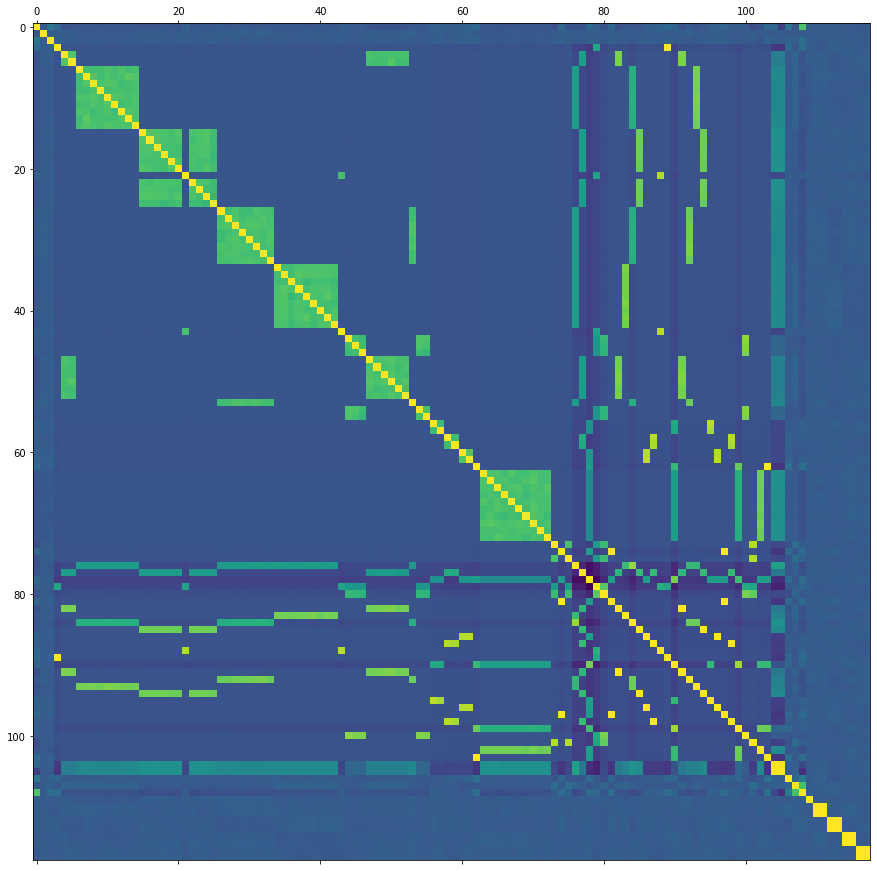

In [15]:
f = plt.figure(figsize=(15, 15))
plt.matshow(features.corr(), fignum=f.number)
plt.show()

## Mutual information

In [16]:
columns = features.columns.to_series()
mutual_info = columns.apply(lambda c: metrics.mutual_info_score(features[c], features.made_purchase))
corr = features.corr().made_purchase
information = pd.DataFrame(data={'mi': mutual_info, 'co': corr.abs(), 'both': mutual_info * corr.abs()})
information.sort_values(by='both', ascending=False)

,mi,co,both
made_purchase,6.207918e-01,1.000000,6.207918e-01
mean_time_per_product,3.811512e-01,0.609886,2.324588e-01
total_duration,1.726258e-01,0.154606,2.668900e-02
mean_event_duration,1.941896e-01,0.029992,5.824189e-03
events_count,1.071022e-01,0.052173,5.587851e-03
...,...,...,...
1278.0,4.451608e-05,0.009484,4.221873e-07
1072.0,3.917067e-05,0.008798,3.446279e-07
zestawy głośnomówiące,1.975826e-05,0.006267,1.238258e-07
1074.0,1.498781e-05,0.005454,8.174374e-08


## Testing features

In [43]:
def test_features(df: pd.DataFrame, indicator: pd.Series):
    results = pd.DataFrame(columns=['features', 'score'])
    for f in range(len(df.columns), 2, -5):
        best = indicator.nlargest(f).index
        x_cols = best.drop('made_purchase').tolist()
        y_col = 'made_purchase'
        score = train_and_test(features[best].reset_index(drop=True), x_cols, y_col, runs=1, silent=True)
        results = results.append({'count': f, 'score': score, 'features': x_cols}, ignore_index=True)
    return results

### Based on mutual information and correlation

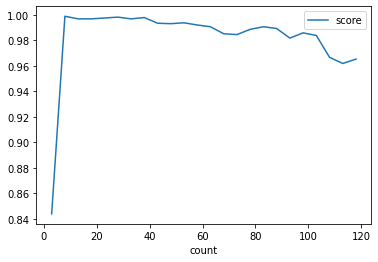

In [30]:
results_both = test_features(features, information.both)
results_both.plot(x='count', y='score')

In [31]:
results_both.sort_values(by='score', ascending=False).head(2)

,features,score,count
22,"Index(['made_purchase', 'mean_time_per_product...",0.998971,8.0
18,"Index([ 'made_purchase', ...",0.998285,28.0


### Based on correlation

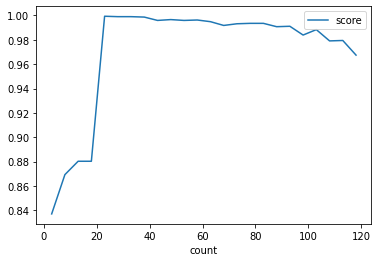

In [49]:
results_co = test_features(features, information.co)
results_co.plot(x='count', y='score')

In [50]:
results_co.sort_values(by='score', ascending=False).head(2)

,features,score,count
19,"[mean_time_per_product, total_duration, produc...",0.999314,23.0
18,"[mean_time_per_product, total_duration, produc...",0.998971,28.0


### Based on mutual information

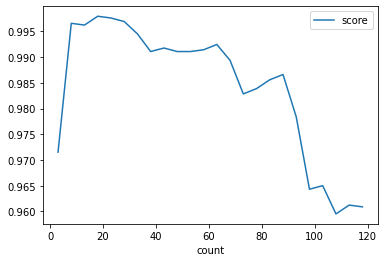

In [34]:
results_mi = test_features(features, information.mi)
results_mi.plot(x='count', y='score')

In [35]:
results_mi.sort_values(by='score', ascending=False).head(2)

,features,score,count
20,"Index([ 'made_purchase', 'mean_time_per...",0.997942,18.0
19,"Index([ 'made_purchase', ...",0.997599,23.0


# Saving model

In [59]:
all_results = pd.concat([results_both, results_co, results_mi], axis=0).reset_index()
best_result = all_results.loc[all_results.score.idxmax()]
print(f'Best results obtained with {best_result.count} features')
features = features[best_result.features ['made_purchase']]

Best results obtained with <bound method Series.count of index                                                      19
features    [mean_time_per_product, total_duration, produc...
score                                                0.999314
count                                                      23
Name: 43, dtype: object> features


In [61]:
x_cols = best_result.features
y_col = 'made_purchase'
train, test = train_test_split(features[best_results.features], test_size=0.3)
clf = svm.SVC()
clf.fit(train[x_cols], train[y_col])
correct = test[y_col] == clf.predict(test[x_cols])
print(f'Final result: {correct.sum() / len(correct)}')

KeyError: "['weekday_sin_min', 1025.0, 1281.0, 1284.0, 1285.0, 1030.0, 1032.0, 1033.0, 1034.0, 1035.0, 1036.0, 1037.0, 1038.0, 1039.0, 1040.0, 1041.0, 1042.0, 1043.0, 1044.0, 1045.0, 1046.0, 1047.0, 1048.0, 1049.0, 1050.0, 1051.0, 1052.0, 1053.0, 1055.0, 1056.0, 1057.0, 'telefony i akcesoria', 1067.0, 'is_female', 1072.0, 1073.0, 1074.0, 1075.0, 1076.0, 1077.0, 1078.0, 1079.0, 1080.0, 'weekday_sin_max', 'weekday_cos_min', 1084.0, 'gry komputerowe', 'hour_sin_min', 'gry na konsole', 'monitory', 'weekday_cos_max', 1287.0, 'tablety', 1288.0, 'komputery', 1289.0, 1290.0, 1291.0, 'anteny rtv', 1292.0, 'odtwarzacze mp3 i mp4', 1293.0, 'hour_cos_max', 'tablety i akcesoria', 'hour_cos_min', 'monitory lcd', 'przenośne audio i video', 'mean_event_duration', 'telewizory i akcesoria', 'gry xbox 360', 'telefony komórkowe', 'gry playstation3', 'zestawy głośnomówiące', 1201.0, 'user_id', 1222.0, 'video', 1233.0, 1234.0, 1002.0, 1004.0, 1005.0, 1006.0, 1007.0, 1008.0, 1009.0, 1010.0, 'odtwarzacze dvd', 1012.0, 1013.0, 'hour_sin_max', 1017.0, 1276.0, 1277.0, 1278.0] not in index"

In [ ]:
dump(clf, 'filename.joblib') 